<a href="https://colab.research.google.com/github/Baptiste54131/M2PFA_AI/blob/main/notebooks/lab_session_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Name : Lassalle Baptiste


E-mail : baptiste.lassalle@live.fr


# Useful Jupyter Notebook Shortcuts

Here are some helpful keyboard shortcuts for Jupyter Notebook:

- **M**: Switch to Markdown mode
- **Y**: Switch to Code mode
- **A**: Insert cell above
- **B**: Insert cell below
- **D, D**: (Press D twice) Delete selected cell
- **Shift + Enter**: Run the current cell and move to the next
- **Ctrl + Enter**: Run the current cell and stay on it
- **Shift + Tab**: Show function/method documentation
- **Ctrl + Shift + -**: Split cell at cursor
- **Esc**: Enter command mode (blue border)
- **Enter**: Enter edit mode (green border)


## default imports

In [1]:
# import for internal use
from urllib.error import URLError
from tensorflow.data import Dataset
import os
from pathlib import Path
import tensorflow as tf
from keras.utils import image_dataset_from_directory, get_file

In [2]:
# general imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [205]:
# data analysis import
from skimage import io, img_as_float
from scipy import stats
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_squared_error as mse

In [4]:
# machine learning imports
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense, Conv1D, Conv2D, UpSampling2D, MaxPooling2D, AveragePooling2D, Rescaling, Activation, Add, Flatten, Reshape
from keras.models import Sequential, Model
from keras import optimizers, regularizers
from sklearn.metrics import r2_score, mean_absolute_percentage_error



## internal functions

In [5]:
from typing import Union
import tensorflow as tf

def transpose_image_grayscale(image: tf.Tensor) -> tf.Tensor:
    """
    Transpose a grayscale image from portrait to landscape orientation if necessary.

    This function checks the dimensions of the input image and transposes it if
    the height (first dimension) is less than the width (second dimension).
    The transposition ensures the image is always in landscape orientation.

    Parameters
    ----------
    image : tf.Tensor
        A 3D tensor representing a grayscale image with shape (height, width, 1).
        The last dimension represents the single color channel.

    Returns
    -------
    tf.Tensor
        A 3D tensor with the same content as the input image, but guaranteed to be
        in landscape orientation (width >= height).

    Notes
    -----
    The function assumes the input is a valid TensorFlow tensor representing
    a grayscale image with three dimensions (height, width, channel).

    Examples
    --------
    >>> import tensorflow as tf
    >>> # Create a portrait grayscale image (5x3x1)
    >>> portrait_image = tf.random.normal([5, 3, 1])
    >>> landscape_result = transpose_image_grayscale(portrait_image)
    >>> print(tf.shape(landscape_result).numpy())
    [3 5 1]

    >>> # Create a landscape grayscale image (3x5x1)
    >>> landscape_image = tf.random.normal([3, 5, 1])
    >>> result = transpose_image_grayscale(landscape_image)
    >>> print(tf.shape(result).numpy())
    [3 5 1]

    See Also
    --------
    tf.transpose : The underlying TensorFlow operation used for transposition.

    Raises
    ------
    ValueError
        If the input tensor does not have exactly 3 dimensions.
    """
    # Check if image is in portrait mode
    if tf.shape(image)[0] < tf.shape(image)[1]:
        # Transpose to landscape mode
        return tf.transpose(image, perm=[1, 0, 2])  # No need for channel dim in grayscale
    else:
        # If it's already landscape, return the image as is
        return image

## Public Functions

In [7]:
def load_and_create_datasets(
    url: str,
    fname: str,
    batch_size: int = 16,
    image_size: tuple[int, int] = (480, 320)
) -> tuple[Dataset, Dataset]:
    """
    Load and prepare image datasets for denoising tasks.

    This function downloads a dataset, extracts it, and creates TensorFlow datasets
    for training and testing. It handles both original (clean) and noisy images,
    applying necessary preprocessing steps including transposition and normalization.

    Parameters
    ----------
    url : str
        URL or local path to the dataset zip file.
    fname : str
        Filename to save the downloaded dataset.
    batch_size : int, optional
        Batch size for the datasets, by default 16.
    image_size : tuple of int, optional
        Target size for the images (height, width), by default (480, 320).

    Returns
    -------
    Tuple[Dataset, Dataset]
        A tuple containing:
        - dataset_train: A TensorFlow Dataset containing pairs of (noisy, original) images for training
        - dataset_test: A TensorFlow Dataset containing pairs of (noisy, original) images for testing

    Notes
    -----
    The function performs several steps:
    1. Downloads and extracts the dataset
    2. Creates separate datasets for original and noisy images, both for training and testing
    3. Applies image transposition to ensure consistent orientation
    4. Normalizes pixel values from [0, 255] to [0, 1]

    The expected dataset structure after extraction is:
    - BSD400/original/ (training original images)
    - BSD400/noise_gaussian_15/ (training noisy images)
    - BSD68/original/ (testing original images)
    - BSD68/noise_gaussian_15/ (testing noisy images)

    Examples
    --------
    >>> url = "https://example.com/dataset.zip"
    >>> fname = "denoising_dataset.zip"
    >>> train_ds, test_ds = load_and_create_datasets(url, fname)
    >>> for noisy_batch, clean_batch in train_ds.take(1):
    ...     print(f"Batch shape: {noisy_batch.shape}")

    Raises
    ------
    Exception
        If the URL download fails, it attempts to use the URL as a local filename.

    Notes
    -----
    - All images are loaded in grayscale mode
    - Images are automatically transposed if needed using the transpose_image_grayscale function
    - Pixel values are rescaled from 0-255 to 0-1
    - The function uses a specific file hash for verification

    See Also
    --------
    transpose_image_grayscale : Function used for ensuring consistent image orientation
    tensorflow.keras.utils.get_file : Used for downloading and extracting the dataset
    """
    image_size = tuple(image_size[0:2])
    dset_name = Path(fname).stem

    FileHash = r"d68e70fa5e9ba1ae4d36dd40a0095f1e1bb49d6574c0372eb5079c636fce0651"

    try:
        dset_download = get_file(fname=fname,
            origin=url,
            extract=True,
            file_hash=FileHash,
            archive_format="zip",
            force_download=False
        )
    except Exception:
            print("URL download failed, try using DATASET_URL as a local filename")
            dset_download = get_file(fname=fname,
                                          origin  = "file:\\"+url,
            extract=True,
            file_hash=FileHash,
            archive_format="zip",
            force_download=False
        )


    # Step 2: Get the path of the extracted directory
    dataset_dir = os.path.dirname(dset_download)
    image_dataset_from_directory_common_args = {
        "label_mode":None,
        "class_names":None,
        "color_mode":"grayscale",
        "batch_size":batch_size,
        "image_size":image_size,
        "shuffle":False,
        "seed":42,
        "validation_split":None,
        "subset":None,
        "interpolation":"bilinear",
        "follow_links":False,
        "crop_to_aspect_ratio":False,
        "pad_to_aspect_ratio":False,
        "data_format":None,
        "verbose":False,
    }

    train_images_original = image_dataset_from_directory(
        Path(dataset_dir).joinpath(dset_name, "BSD400","original"),
        **image_dataset_from_directory_common_args
    )

    train_images_noisy = image_dataset_from_directory(
        Path(dataset_dir).joinpath(dset_name, "BSD400","noise_gaussian_15"),
        **image_dataset_from_directory_common_args
    )

    test_images_original = image_dataset_from_directory(
        Path(dataset_dir).joinpath(dset_name, "BSD68", "original"),
        **image_dataset_from_directory_common_args
    )

    test_images_noisy = image_dataset_from_directory(
        Path(dataset_dir).joinpath(dset_name, "BSD68", "noise_gaussian_15"),
        **image_dataset_from_directory_common_args
    )



    # Apply the transpose function for grayscale images
    train_images_original = train_images_original.map(lambda x: tf.map_fn(transpose_image_grayscale, x))
    test_images_original = test_images_original.map(lambda x: tf.map_fn(transpose_image_grayscale, x))
    train_images_noisy = train_images_noisy.map(lambda x: tf.map_fn(transpose_image_grayscale, x))
    test_images_noisy = test_images_noisy.map(lambda x: tf.map_fn(transpose_image_grayscale, x))


    rescale = Rescaling(1.0 / 255)

    # Apply the Rescaling layer for normalization to both datasets
    train_images_original = train_images_original.map(lambda x: rescale(x))
    test_images_original = test_images_original.map(lambda x: rescale(x))
    train_images_noisy = train_images_noisy.map(lambda x: rescale(x))
    test_images_noisy = test_images_noisy.map(lambda x: rescale(x))


    dataset_train = Dataset.zip((train_images_noisy, train_images_original))
    dataset_test = Dataset.zip((test_images_noisy, test_images_original))
    print("Datasets for train and test, created. Please note that pixels values have been rescale from 0->255 to 0->1")
    return dataset_train, dataset_test

In [8]:
def dataset_to_list(dataset):
    flat_images_noisy = []
    flat_images_original = []

    for noisy_batch, original_batch in dataset:
        # Convert to numpy and flatten the batch dimension
        noisy_images = noisy_batch.numpy()
        original_images = original_batch.numpy()

        # Extend our lists with the flattened batches
        flat_images_noisy.extend(noisy_images)
        flat_images_original.extend(original_images)

    return tuple([x.squeeze() for x in flat_images_noisy]), tuple([x.squeeze() for x in flat_images_original])

In [9]:
   def fourier_denoise(image, threshold=0.1):
       # Compute the 2D FFT of the image
       f = np.fft.fft2(image)

       # Shift the zero-frequency component to the center
       f_shift = np.fft.fftshift(f)

       # Create a mask based on the threshold
       mask = np.abs(f_shift) > threshold * np.max(np.abs(f_shift))

       # Apply the mask
       f_shift_filtered = f_shift * mask

       # Shift back
       f_filtered = np.fft.ifftshift(f_shift_filtered)

       # Compute the inverse 2D FFT
       denoised = np.real(np.fft.ifft2(f_filtered))

       return np.clip(denoised, 0., 1.), f_shift, f_shift_filtered

## global variables

In [10]:
DATASET_URL = "https://amubox.univ-amu.fr/s/TP3mLFKikYdxt7o/download/dataset_bsd400_68.zip"
DATASET_FNAME = "dataset_bsd400_68.zip"
# images downsampled to reduce memory usage during training
IMAGE_SHAPE = (240, 160, 1) # last value correspond to the number of channels : 1 for grayscale, 3 for rgb

# Dataset Loading

In [11]:
dataset_train, dataset_test = load_and_create_datasets(DATASET_URL, DATASET_FNAME, image_size=IMAGE_SHAPE)

182766331/182766331 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step
Datasets for train and test, created. Please note that pixels values have been rescale from 0->255 to 0->1


In [17]:
images_noise_test, images_ref_test = dataset_to_list(dataset_test)
images_noise_train, images_ref_train = dataset_to_list(dataset_train)

In [49]:

plt.imshow(images_noise_train[i])



NameError: name 'i' is not defined

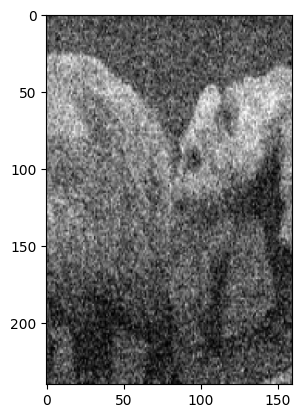

In [55]:
plt.imshow(images_noise_train[0], cmap = 'gray')


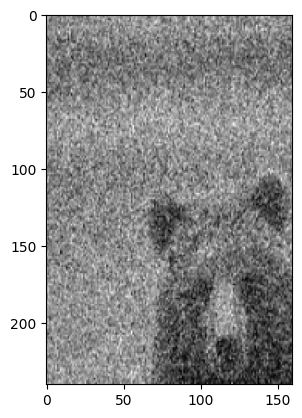

In [57]:
plt.imshow(images_noise_train[1], cmap = 'gray')

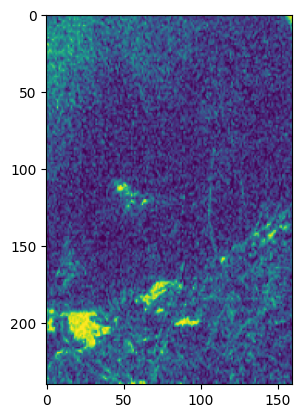

In [30]:
plt.imshow(images_noise_train[2])

## Dataset Analysis

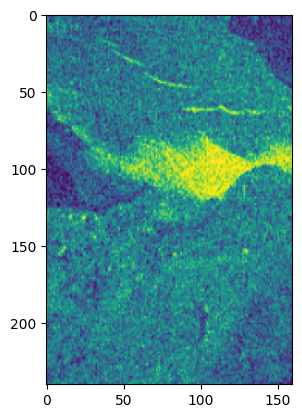

In [31]:
plt.imshow(images_noise_train[3])

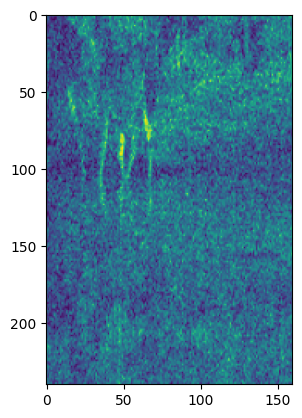

In [32]:
plt.imshow(images_noise_train[4])

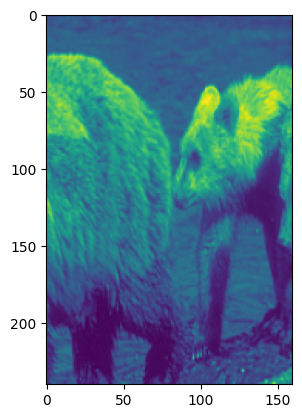

In [35]:
plt.imshow(images_ref_train[0])

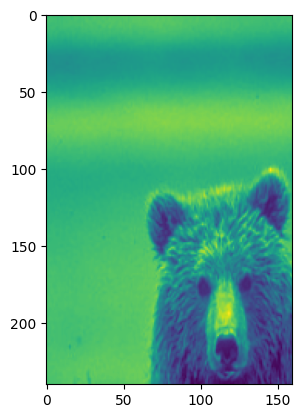

In [38]:
plt.imshow(images_ref_train[1])

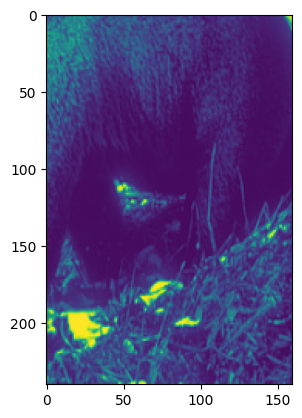

In [39]:
plt.imshow(images_ref_train[2])

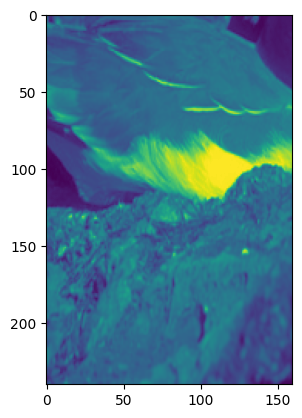

In [40]:
plt.imshow(images_ref_train[3])

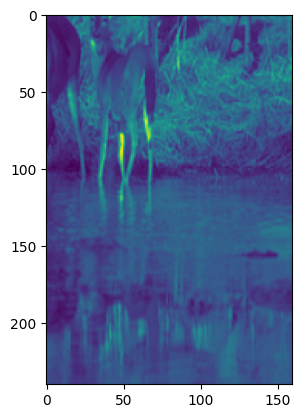

In [41]:
plt.imshow(images_ref_train[4])

In [79]:
len(images_noise_train)

400

In [70]:
'''
for i in range(len(images_noise_train)):

    difference = images_ref_train[i] - images_noise_train[i]

    plt.hist(images_ref_train[i].flatten(), bins = 100, color = 'blue')
    plt.title('Histogram of image' i)
    plt.show()

    plt.hist(images_noise_train[i].flatten(), bins = 100, color = 'red')
    plt.title('Histogram of image' i)
    plt.show()

    plt.hist(difference.flatten(), bins = 100, color = 'green')
    plt.title('Histogram of difference of image'i)
    plt.show()
'''
#Histograms de chaque image (référence, train, différence).

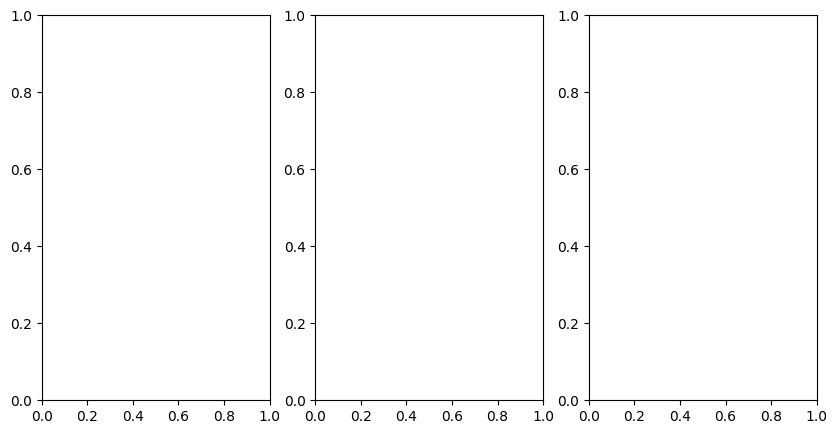

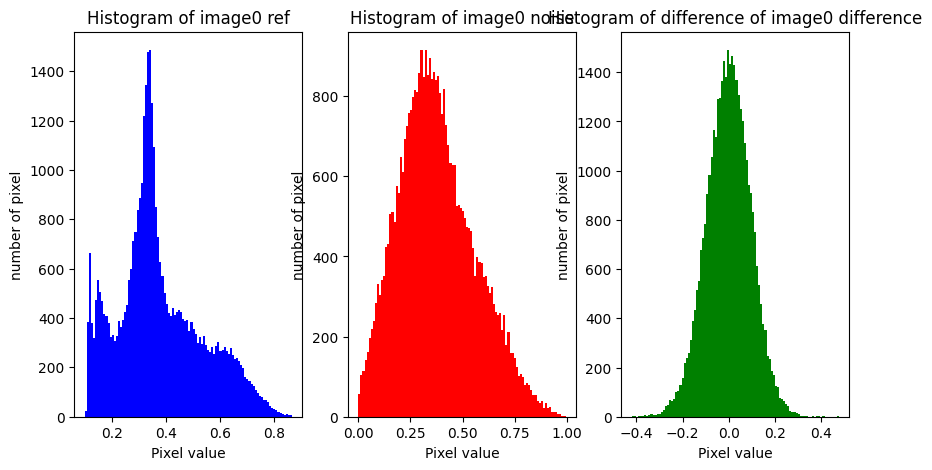

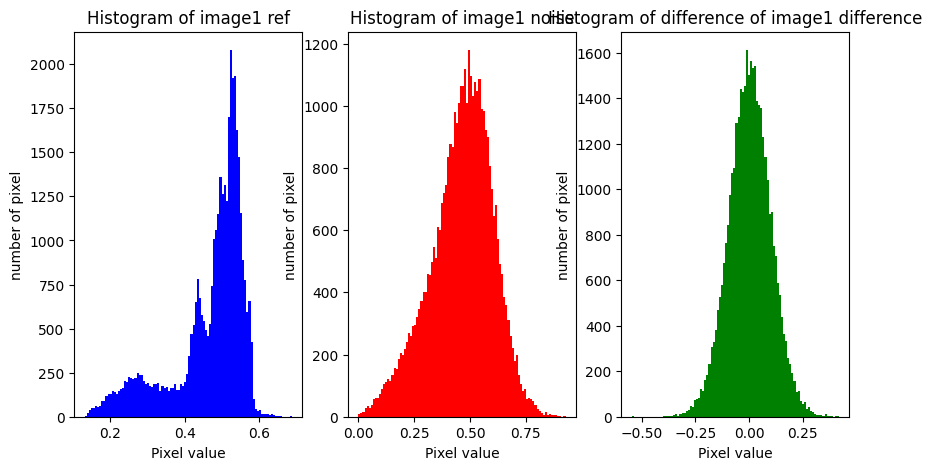

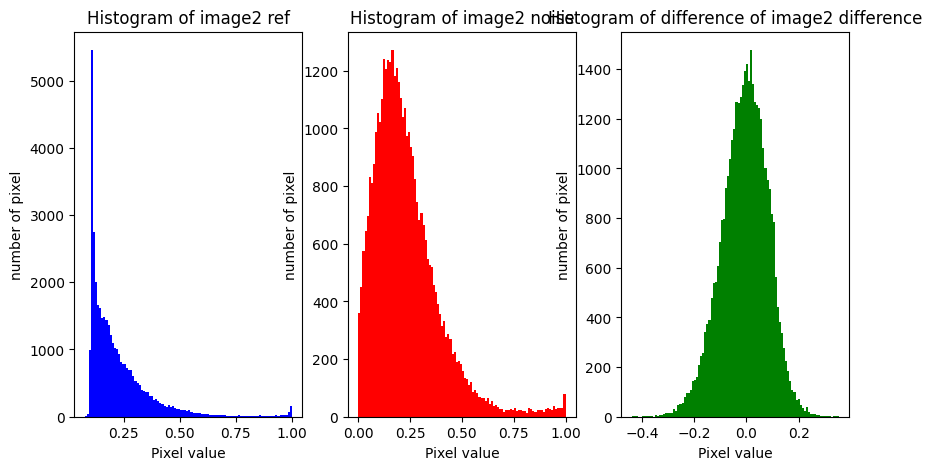

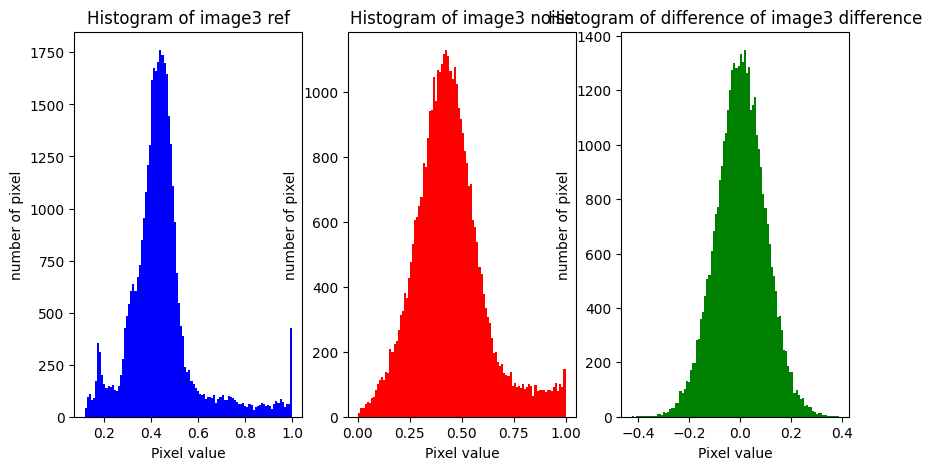

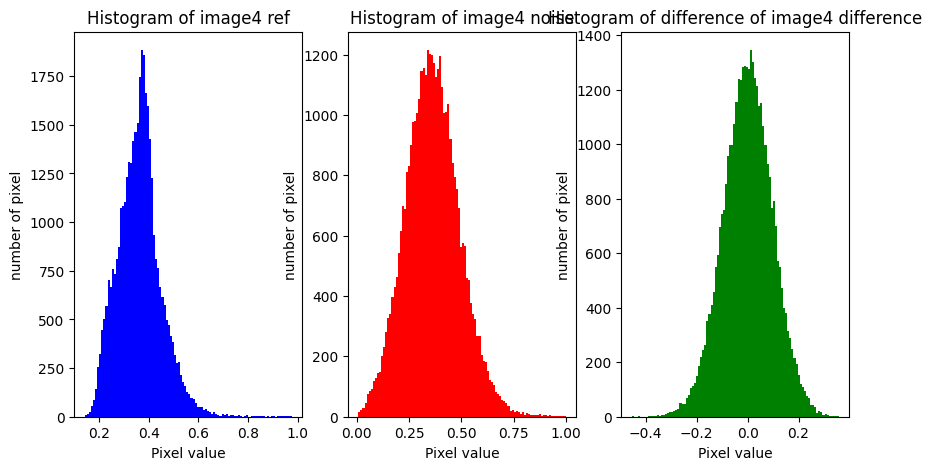

In [163]:
#Pour seulement les 5 premières images
fig, Axes = plt.subplots(1,3, figsize=(10,5)) # 1 row, 3 columns
for i in range(5):
    fig, Axes = plt.subplots(1,3, figsize=(10,5)) # 1 row, 3 columns

    difference = images_ref_train[i] - images_noise_train[i]

    Axes[0].hist(images_ref_train[i].flatten(), bins = 100, color = 'blue')
    Axes[0].set_title('Histogram of image' + str(i) + ' ref')
    Axes[0].set_xlabel('Pixel value')
    Axes[0].set_ylabel('number of pixel')

    Axes[1].hist(images_noise_train[i].flatten(), bins = 100, color = 'red')
    Axes[1].set_title('Histogram of image' + str(i) + ' noise')
    Axes[1].set_xlabel('Pixel value')
    Axes[1].set_ylabel('number of pixel')

    Axes[2].hist(difference.flatten(), bins = 100, color = 'green')
    Axes[2].set_title('Histogram of difference of image' + str(i) + ' difference')
    Axes[2].set_xlabel('Pixel value')
    Axes[2].set_ylabel('number of pixel')
    plt.show()

In [ ]:
'''
All ref and train histograms seem very different, however their difference seem about the same, embracing gloablly a gaussian shape. Which means that the amount of added noise and its distribution is about the same. So if we can filter it for one of them, we can filter it for all of them.
'''

In [139]:

      mse_value = []
      mae_value = []
      psnr_value = []
      ssim_value = []

      for i in range(len(images_noise_test)):


        # Calculate Mean Squared Error (MSE)
        mse_value.append(np.mean((images_noise_test[i].flatten() - images_ref_test[i].flatten())**2))

          # Calculate Mean Average Error (MAE)
        mae_value.append(np.mean(np.abs(images_ref_test[i].flatten() - images_noise_test[i].flatten())))

        # Calculate Peak Signal-to-Noise Ratio (PSNR)
        psnr_value.append(psnr(images_ref_test[i].flatten(), images_noise_test[i].flatten(), data_range=1))

        # Calculate Structural Similarity Index (SSIM)
        ssim_value.append(ssim(images_ref_test[i].flatten(), images_noise_test[i].flatten(),data_range=1))




      # Store the metrics in a dictionary
      metrics = {
          'MSE': mse_value,
          'MAE' : mae_value,
          'PSNR': psnr_value,
          'SSIM': ssim_value,
          }

In [197]:
#Let's tranform our dictionnary into a table:
df = pd.DataFrame(metrics)

print(df)

         MSE       MAE       PSNR      SSIM
0   0.005087  0.056829  22.935778  0.587728
1   0.005454  0.059153  22.632828  0.428149
2   0.005255  0.057919  22.794614  0.396306
3   0.013667  0.093731  18.643222  0.321978
4   0.012514  0.085956  19.026068  0.423072
..       ...       ...        ...       ...
63  0.005294  0.058180  22.762281  0.542833
64  0.011786  0.082840  19.286398  0.408622
65  0.014140  0.094579  18.495521  0.139979
66  0.005227  0.057630  22.817667  0.693852
67  0.011288  0.080387  19.473739  0.462568

[68 rows x 4 columns]


In [167]:
#Let's create a new table with the average and std of all metrics for all images.
results = {}
for key, values in metrics.items():
    results[key] = {
        'mean': np.mean(values),
        'std': np.std(values)
    }

df_results = pd.DataFrame(results)
print(df_results)

           MSE       MAE       PSNR      SSIM
mean  0.011360  0.083198  19.726316  0.387735
std   0.003402  0.014453   1.703465  0.126453


In [171]:
print(results)

{'MSE': {'mean': 0.011359691, 'std': 0.0034015197}, 'MAE': {'mean': 0.08319807, 'std': 0.014453251}, 'PSNR': {'mean': 19.7263160760952, 'std': 1.7034651611254443}, 'SSIM': {'mean': 0.38773470545731786, 'std': 0.12645257348853617}}


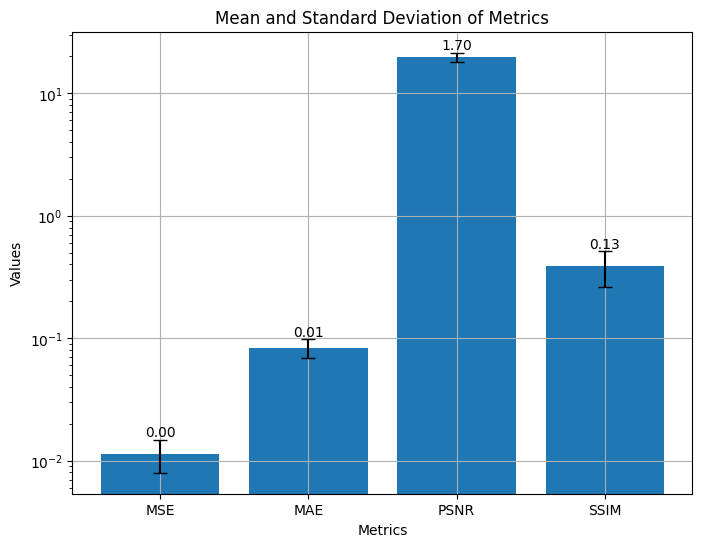

In [181]:
means = df_results.loc['mean'].values  # Access 'mean' row and get values
std_devs = df_results.loc['std'].values  # Access 'std' row and get values

plt.figure(figsize=(8, 6))  # Adjust figure size as needed
plt.bar(df_results.columns, means, yerr=std_devs, capsize=5)  # Error bars for std dev
for i, std in enumerate(std_devs):
    plt.text(df_results.columns[i], means[i] + std, f'{std:.2f}', ha='center', va='bottom')  # Add text with std devb
plt.title('Mean and Standard Deviation of Metrics')
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.yscale('log')  # Logarithmic scale for better visualization
plt.grid(True)

plt.show()

In [ ]:
'''
Not all images are similar, neither the same amount of noise. All metrics are not similar for each image.
'''

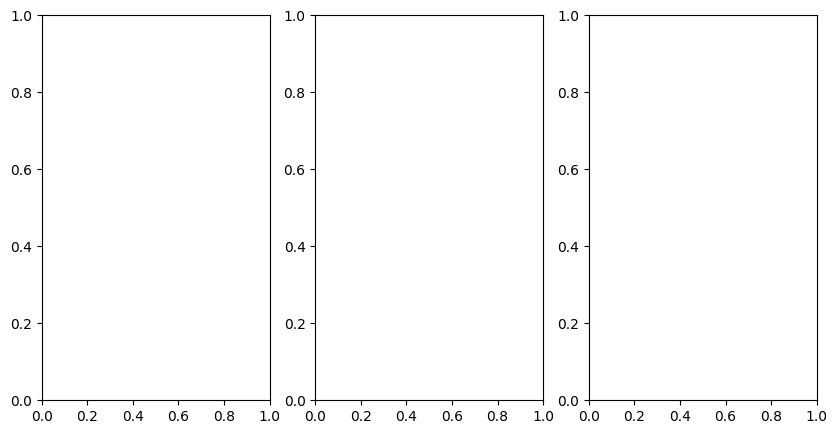

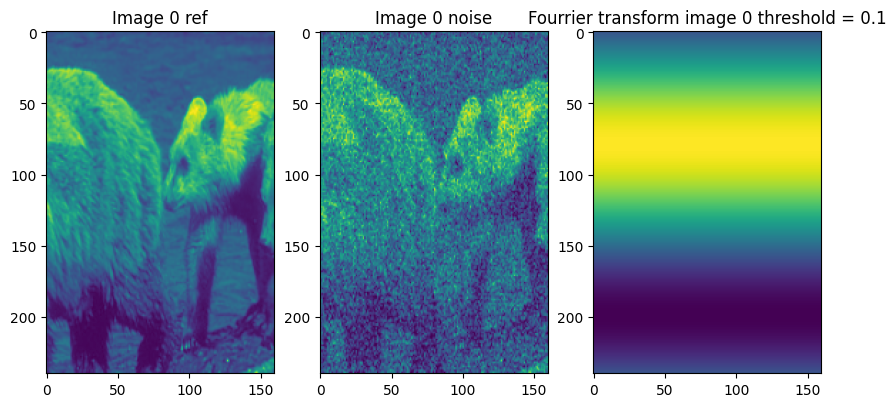

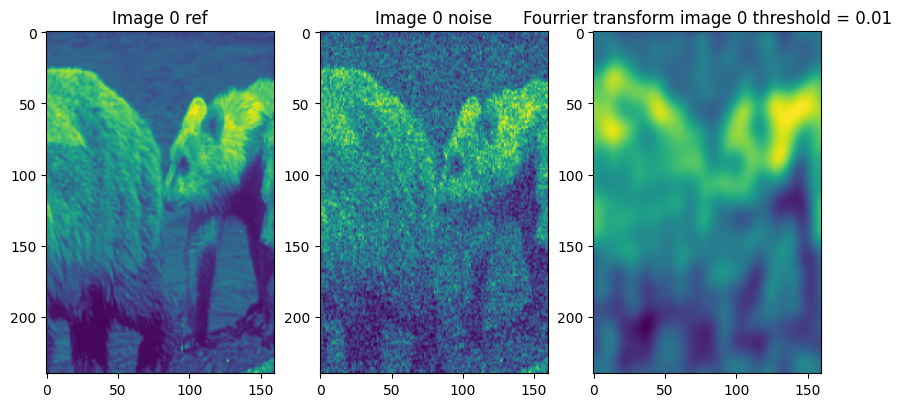

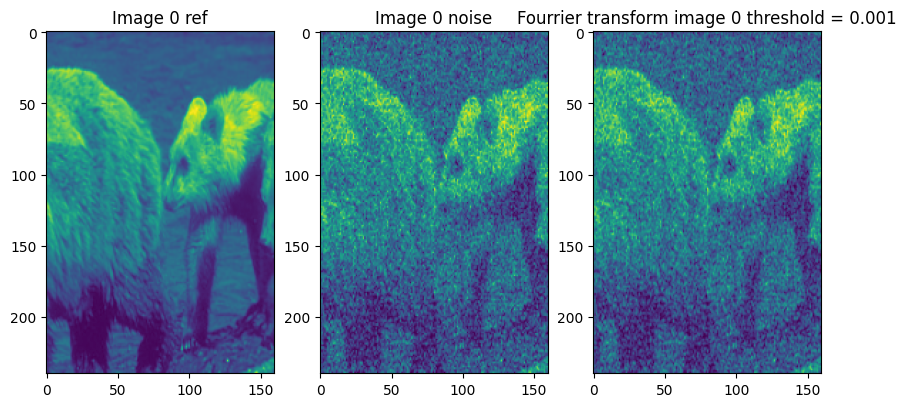

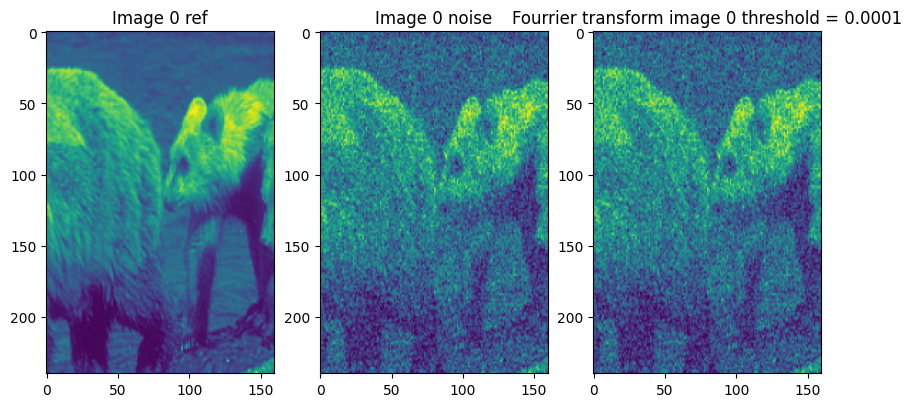

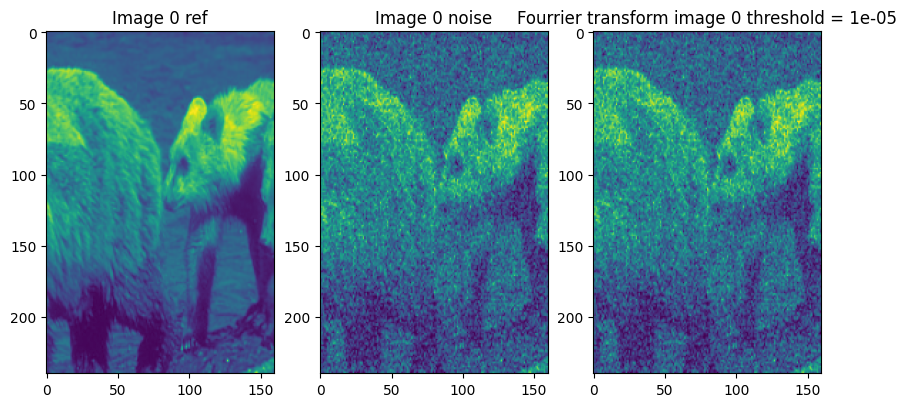

In [196]:
fig, Axes = plt.subplots(1,3, figsize=(10,5)) # 1 row, 3 columns
threshold = [0.1, 0.01, 0.001, 0.0001, 0.00001]
for i in range(5):
    fig, Axes = plt.subplots(1,3, figsize=(10,5)) # 1 row, 3 columns

    denoised_image,_,_ = fourier_denoise(images_noise_train[0], threshold[i])

    Axes[0].imshow(images_ref_train[0])
    Axes[0].set_title('Image 0 ref')

    Axes[1].imshow(images_noise_train[0])
    Axes[1].set_title('Image 0 noise')

    Axes[2].imshow(denoised_image)
    Axes[2].set_title('Fourrier transform image 0 threshold = ' + str(threshold[i]) )

    plt.show()


(array([[0.33753389, 0.3348809 , 0.33277968, ..., 0.346089  , 0.34340326,
         0.34046948],
        [0.33691763, 0.33482113, 0.33315934, ..., 0.34299932, 0.34126717,
         0.33916208],
        [0.33593884, 0.33439494, 0.33317841, ..., 0.3395952 , 0.33879726,
         0.33750388],
        ...,
        [0.33602435, 0.3320401 , 0.32900905, ..., 0.35119175, 0.34589134,
         0.34073693],
        [0.33721751, 0.3335856 , 0.33076523, ..., 0.35042006, 0.34591593,
         0.34142243],
        [0.33767602, 0.33449911, 0.3319998 , ..., 0.34864112, 0.34501943,
         0.34127732]]),
 array([[ 6.06914756+0.j        ,  7.89415478-5.81325996j,
          3.08184671-6.03510274j, ..., -1.75227259-0.97207403j,
          3.08184671+6.03510274j,  7.89415478+5.81325996j],
        [-8.8379779 +5.87757745j,  3.4913453 +0.09919216j,
          1.59601803-2.94681558j, ...,  3.12456613-0.9093595j ,
          4.7975441 -0.66640648j,  1.25952227-0.47272457j],
        [-4.68930389-0.28124014j,  1.747000

(array([[0.11616586, 0.17237799, 0.21478413, ..., 0.33343478, 0.47682848,
         0.26652092],
        [0.28761415, 0.23098183, 0.17234567, ..., 0.35297726, 0.35558655,
         0.53910475],
        [0.34611706, 0.35664317, 0.14546946, ..., 0.41914896, 0.29358285,
         0.51128785],
        ...,
        [0.22832949, 0.26756829, 0.31932659, ..., 0.62008267, 0.42308274,
         0.41479554],
        [0.33356305, 0.28037624, 0.23754625, ..., 0.63333032, 0.34298537,
         0.34293362],
        [0.18624741, 0.20094464, 0.16827578, ..., 0.51356574, 0.33121172,
         0.16503543]]),
 array([[ 6.06914756+0.j        ,  7.89415478-5.81325996j,
          3.08184671-6.03510274j, ..., -1.75227259-0.97207403j,
          3.08184671+6.03510274j,  7.89415478+5.81325996j],
        [-8.8379779 +5.87757745j,  3.4913453 +0.09919216j,
          1.59601803-2.94681558j, ...,  3.12456613-0.9093595j ,
          4.7975441 -0.66640648j,  1.25952227-0.47272457j],
        [-4.68930389-0.28124014j,  1.747000

In [225]:
      denoised_image = []
      for i in range(len(threshold)):
        denoised_image,_,_ = fourier_denoise(images_noise_train[0], threshold[i])
        denoised_image.append(denoised_image,_,_)

AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [222]:

      denoise_mse_value = []
      denoise_mae_value = []
      denoise_psnr_value = []
      denoise_ssim_value = []

#denoised_image,_,_ = fourier_denoise(images_noise_train[0], threshold[i])
#threshold = [0.1, 0.01, 0.001, 0.0001, 0.00001]




      for i in range(len(threshold)):


        #denoised_image,_,_ = fourier_denoise(images_noise_train[0], threshold[i])

        # Calculate Mean Squared Error (MSE)
        denoise_mse_value.append(mse(images_ref_test[i].flatten(), denoised_image,_,_))

        # Calculate Mean Average Error (MAE)
        denoise_mae_value.append(np.mean(np.abs(images_ref_test[i].flatten() - denoised_image_con)))

        # Calculate Peak Signal-to-Noise Ratio (PSNR)
        denoise_psnr_value.append(psnr(images_ref_test[i].flatten(), denoised_image_con , data_range=1))

        # Calculate Structural Similarity Index (SSIM)
        denoise_ssim_value.append(ssim(images_ref_test[i].flatten(), denoised_image_con ,data_range=1))




      # Store the metrics in a dictionary
      d_metrics = {
          'D_MSE': denoise_mse_value,
          'D_MAE' : denoise_mae_value,
          'D_PSNR': denoise_psnr_value,
          'D_SSIM': denoise_ssim_value,
          }

#Let's tranform our dictionnary into a table:
d_df = pd.DataFrame(d_metrics)

print(d_df)

ValueError: Found input variables with inconsistent numbers of samples: [38400, 3]

## Perceptron Autoencoder

## CNN Autoencoder

## Conclustions